In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import os
from tqdm import tqdm
import argparse

from datetime import datetime
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pickle
from sklearn.model_selection import train_test_split
import tifffile as tiff
from skimage import transform as tr #, img_as_ubyte
from models.synesam import *
from trainer.trainvEWC import *
from r2attn import *

ModuleNotFoundError: No module named 'r2attn'

In [2]:
import torch
from torchvision import transforms
import tifffile as tiff
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
import os
import torch.nn.functional as F


transform = transforms.Compose([
    transforms.ToTensor(),
])

class Data_Gen(Dataset):
    def __init__(self, data_path, label_path, test_ids, transform=transform, mode = 'train'):
        self.data_path = data_path
        self.label_path = label_path
        self.transform = transform
        self.mode = mode
        if mode=='train':
            self.images = [img for img in os.listdir(data_path) if img[:3] not in test_ids]
            self.labels = [img for img in os.listdir(label_path) if img[:3] not in test_ids]# Print the lengths for debugging
        else:
            self.images = [img for img in os.listdir(data_path) if img[:3] in test_ids]
            self.labels = [img for img in os.listdir(label_path) if img[:3] in test_ids]# Print the lengths for debugging
        print(f"Number of images: {len(self.images)}")
        print(f"Number of labels: {len(self.labels)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        #print(idx)
        img_name = os.path.join(self.data_path, self.images[idx])
        #print(img_name)
        label_name = os.path.join(self.label_path, self.labels[idx])
        image = tiff.imread(img_name)
        #print(image.max())
        image = np.float32(image)
        
        if len(image.shape)==3:        
           image = image.squeeze(0)
        else:
            image = image
        image = image/255
        label = tiff.imread(label_name)
        label = np.float32(label)
        #print(label.shape)


        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
            if label.shape[0]==128:
                label = label.squeeze(1)
                label = label.permute(1,0)
            else:
                label = label.squeeze(0)
            
            
                #label = label.permute(1,0)
            label = label.unsqueeze(0)
            label[label==255] = 1 
            label[label ==128] = 2
            label[label<0] = 0
            #label = label.permute(1,0)
            #print(label.max(), image.max())
            #print(image.shape, label.shape)
        return image.cuda(), label.cuda(), self.images[idx], self.labels[idx]


Number of images: 464
Number of labels: 464
Number of training samples: 464
Image filename: 10_1.tif
Mask filename: 10_1.tif
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
tensor(0.5686, device='cuda:0') tensor(2., device='cuda:0')


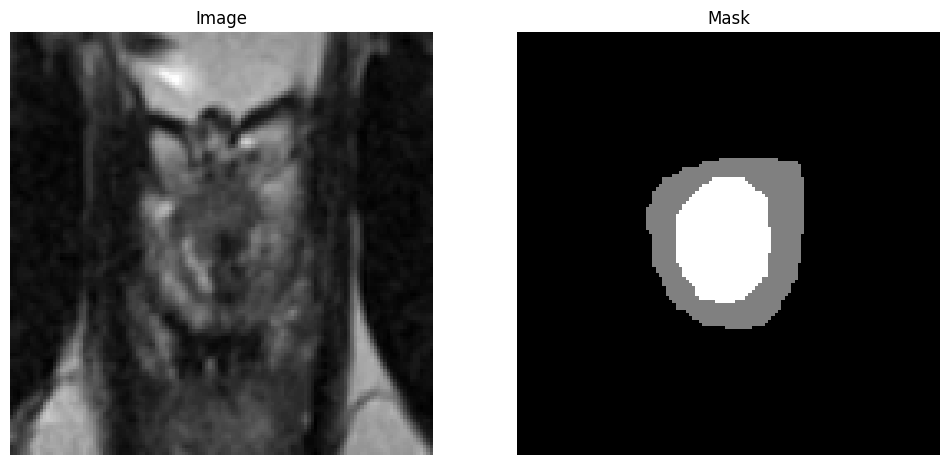

In [3]:
train_data_path = r"D:\PhD\Prostate\Data\GSA\sliced_im"
train_label_path = r"D:\PhD\Prostate\Data\GSA\sliced_lb"

# Create dataset and dataloader
test= ['183_', '184_', '185_', '186_', '187_', '188_', '189_', '190_', '191_', '192_', '193_', '194_', '195_', '196_', '197_', '198_', '199_', '200_', '201_', '202_', '203_', '204_']
test= ['35_', '36_', '37_', '38_', '39_', '41_', '42_', '43_', '44_', '45_']

dataset = Data_Gen(train_data_path, train_label_path, test, mode = 'train')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# Wrap only the first 20 indices of the dataset
#subset = Subset(dataset, range(20))

# Create a DataLoader from the subset
#dataloader = DataLoader(subset, batch_size=1, shuffle=True)
print(f"Number of training samples: {len(dataset)}")


# Retrieve a sample from the dataloader
sample_idx = 1  # Change this index as needed
sample_image, sample_mask, image_filename, mask_filename = dataset[sample_idx]
print("Image filename:", image_filename)
print("Mask filename:", mask_filename)
print(sample_image.shape, sample_mask.shape)
print(sample_image.max(), sample_mask.max())

# Convert torch tensors to numpy arrays
sample_image = sample_image[0,:,:].cpu().numpy()  # Convert from CHW to HWC and move to CPU
sample_mask = sample_mask[0,:,:].cpu().numpy()

# Plot the image and mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the image
axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title('Image')
axes[0].axis('off')

# Plot the mask
axes[1].imshow(sample_mask, cmap='gray')  # Assuming mask is grayscale
axes[1].set_title('Mask')
axes[1].axis('off')

plt.show()





Number of images: 146
Number of labels: 146
Number of validation samples: 146
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
Test Image filename: 35_13.tif
Test Mask filename: 35_13.tif


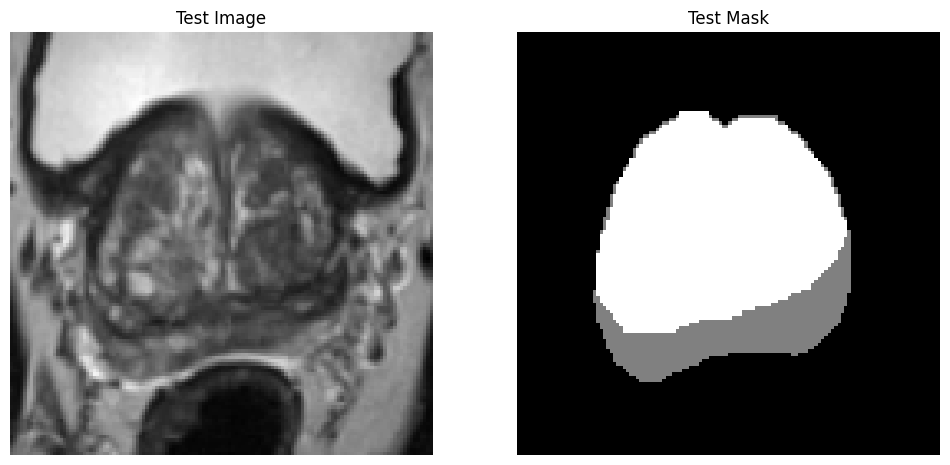

In [4]:
#test= ['35_', '36_', '37_', '38_', '39_', '41_', '42_', '43_', '44_', '45_']

test_dataset = Data_Gen(train_data_path, train_label_path, test, mode = 'test')

#if len(test_dataset) % 16 != 0:
#    test_dataset.images.append(test_dataset.images[-1])
#    test_dataset.labels.append(test_dataset.labels[-1])

#pad_by = (16 - len(test_dataset) % 16) % 16
#for _ in range(pad_by):
#    test_dataset.images.append(test_dataset.images[-1])
#    test_dataset.labels.append(test_dataset.labels[-1])
    
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


print(f"Number of validation samples: {len(test_dataset)}")

# Retrieve a sample from the test dataloader
sample_idx_test = 5  # Change this index as needed
sample_image_test, sample_mask_test, image_filename_test, mask_filename_test = test_dataset[sample_idx_test]
print(sample_image_test.shape, sample_mask_test.shape)

print("Test Image filename:", image_filename_test)
print("Test Mask filename:", mask_filename_test)

# Convert torch tensors to numpy arrays
sample_image_test = sample_image_test[0,:,:].cpu().numpy()  # Convert from CHW to HWC and move to CPU
sample_mask_test = sample_mask_test[0,:,:].cpu().numpy()

# Plot the test image and mask
fig_test, axes_test = plt.subplots(1, 2, figsize=(12, 6))

# Plot the test image
axes_test[0].imshow(sample_image_test, cmap='gray')
axes_test[0].set_title('Test Image')
axes_test[0].axis('off')

# Plot the test mask
axes_test[1].imshow(sample_mask_test, cmap='gray')  # Assuming mask is grayscale
axes_test[1].set_title('Test Mask')
axes_test[1].axis('off')

plt.show()


In [5]:
model = SynDSAM(128, 1, 3).to('cuda')
#checkpoint_path = r"C:\Users\UAB\CK_WorkPlace\PhD\Prostate\synsam\wp\Main\synesam_x_vewc\synesam_uab_vewc_best_metric_model.pth"  # replace with actual path
#state_dict = torch.load(checkpoint_path)

# If the model was saved with `model.state_dict()`:
#model.load_state_dict(state_dict)
loss_function = monai.losses.DiceFocalLoss(to_onehot_y=True, sigmoid=False,softmax=True,include_background=True)

torch.backends.cudnn.benchmark = True

post_label = monai.transforms.AsDiscrete(to_onehot=3)
post_pred = monai.transforms.Compose([
        monai.transforms.AsDiscrete(argmax=True, to_onehot=3, num_classes=3),
        monai.transforms.KeepLargestConnectedComponent(),]
    )
dice_metric = monai.metrics.DiceMetric(include_background=False, reduction="mean_batch", get_not_nans=False,ignore_empty=True)
iou_metric=monai.metrics.MeanIoU(include_background=False,reduction="mean_batch",get_not_nans=False,ignore_empty=True)

optimizer = monai.optimizers.Novograd(model.parameters(), lr=0.001, weight_decay=0.01)

model_dir= './wp/modes/syndsam_x'
#cl_dir=r'C:\Users\UAB\CK_WorkPlace\PhD\Prostate\synsam\wp\Main\synesam_x_vewc'
os.makedirs(model_dir, exist_ok = True) 


trainv2D(model, dataloader, test_dataloader, loss_function, optimizer, 300, model_dir,device='cuda',cl_dir=None,name='syndsam_x',test_interval=1)


----------
epoch 1/300


Epoch 1: 100%|████████████████████████████████████| 2679/2679 [01:54<00:00, 23.41batch/s, dice_score=0.578, loss=0.333]


Train Loss: 0.4540, Dice: 0.5782, IoU: 0.4570
[TEST] Loss: 0.4474, Dice: 0.6385, IoU: 0.4998
[INFO] Best model updated and saved at epoch 1
----------
epoch 2/300


Epoch 2: 100%|████████████████████████████████████| 2679/2679 [01:48<00:00, 24.78batch/s, dice_score=0.725, loss=0.346]


Train Loss: 0.3829, Dice: 0.7247, IoU: 0.5941
[TEST] Loss: 0.3897, Dice: 0.7053, IoU: 0.5690
[INFO] Best model updated and saved at epoch 2
----------
epoch 3/300


Epoch 3: 100%|████████████████████████████████████| 2679/2679 [01:50<00:00, 24.20batch/s, dice_score=0.754, loss=0.236]


Train Loss: 0.3589, Dice: 0.7536, IoU: 0.6281
[TEST] Loss: 0.3845, Dice: 0.7145, IoU: 0.5809
[INFO] Best model updated and saved at epoch 3
----------
epoch 4/300


Epoch 4: 100%|████████████████████████████████████| 2679/2679 [01:57<00:00, 22.89batch/s, dice_score=0.767, loss=0.331]


Train Loss: 0.3470, Dice: 0.7674, IoU: 0.6445
[TEST] Loss: 0.3667, Dice: 0.7379, IoU: 0.6053
[INFO] Best model updated and saved at epoch 4
----------
epoch 5/300


Epoch 5: 100%|█████████████████████████████████████| 2679/2679 [01:54<00:00, 23.41batch/s, dice_score=0.775, loss=0.26]


Train Loss: 0.3394, Dice: 0.7750, IoU: 0.6538
[TEST] Loss: 0.3574, Dice: 0.7436, IoU: 0.6123
[INFO] Best model updated and saved at epoch 5
----------
epoch 6/300


Epoch 6: 100%|████████████████████████████████████| 2679/2679 [01:54<00:00, 23.45batch/s, dice_score=0.779, loss=0.233]


Train Loss: 0.3362, Dice: 0.7788, IoU: 0.6585
[TEST] Loss: 0.4019, Dice: 0.7034, IoU: 0.5681
----------
epoch 7/300


Epoch 7: 100%|████████████████████████████████████| 2679/2679 [01:54<00:00, 23.42batch/s, dice_score=0.781, loss=0.607]


Train Loss: 0.3345, Dice: 0.7809, IoU: 0.6609
[TEST] Loss: 0.3910, Dice: 0.7072, IoU: 0.5722
----------
epoch 8/300


Epoch 8: 100%|████████████████████████████████████| 2679/2679 [01:54<00:00, 23.42batch/s, dice_score=0.784, loss=0.302]


Train Loss: 0.3317, Dice: 0.7836, IoU: 0.6641
[TEST] Loss: 0.3720, Dice: 0.7399, IoU: 0.6093
----------
epoch 9/300


Epoch 9: 100%|████████████████████████████████████| 2679/2679 [02:05<00:00, 21.35batch/s, dice_score=0.786, loss=0.246]


Train Loss: 0.3291, Dice: 0.7859, IoU: 0.6671
[TEST] Loss: 0.3763, Dice: 0.7388, IoU: 0.6082
----------
epoch 10/300


Epoch 10: 100%|███████████████████████████████████| 2679/2679 [02:06<00:00, 21.14batch/s, dice_score=0.788, loss=0.269]


Train Loss: 0.3293, Dice: 0.7875, IoU: 0.6692
[TEST] Loss: 0.3463, Dice: 0.7628, IoU: 0.6355
[INFO] Best model updated and saved at epoch 10
----------
epoch 11/300


Epoch 11: 100%|████████████████████████████████████| 2679/2679 [02:01<00:00, 22.13batch/s, dice_score=0.788, loss=0.36]


Train Loss: 0.3279, Dice: 0.7880, IoU: 0.6696
[TEST] Loss: 0.3536, Dice: 0.7508, IoU: 0.6236
----------
epoch 12/300


Epoch 12: 100%|███████████████████████████████████| 2679/2679 [01:56<00:00, 23.05batch/s, dice_score=0.789, loss=0.228]


Train Loss: 0.3254, Dice: 0.7893, IoU: 0.6713
[TEST] Loss: 0.3476, Dice: 0.7588, IoU: 0.6324
----------
epoch 13/300


Epoch 13: 100%|████████████████████████████████████| 2679/2679 [01:48<00:00, 24.79batch/s, dice_score=0.79, loss=0.628]


Train Loss: 0.3253, Dice: 0.7897, IoU: 0.6721
[TEST] Loss: 0.3799, Dice: 0.7197, IoU: 0.5892
----------
epoch 14/300


Epoch 14: 100%|███████████████████████████████████| 2679/2679 [01:51<00:00, 24.12batch/s, dice_score=0.791, loss=0.249]


Train Loss: 0.3236, Dice: 0.7914, IoU: 0.6739
[TEST] Loss: 0.3848, Dice: 0.7155, IoU: 0.5838
----------
epoch 15/300


Epoch 15: 100%|███████████████████████████████████| 2679/2679 [01:51<00:00, 24.10batch/s, dice_score=0.794, loss=0.694]


Train Loss: 0.3211, Dice: 0.7936, IoU: 0.6765
[TEST] Loss: 0.3528, Dice: 0.7499, IoU: 0.6237
----------
epoch 16/300


Epoch 16: 100%|███████████████████████████████████| 2679/2679 [01:51<00:00, 23.99batch/s, dice_score=0.794, loss=0.561]


Train Loss: 0.3208, Dice: 0.7940, IoU: 0.6770
[TEST] Loss: 0.3542, Dice: 0.7529, IoU: 0.6259
----------
epoch 17/300


Epoch 17: 100%|███████████████████████████████████| 2679/2679 [01:58<00:00, 22.60batch/s, dice_score=0.795, loss=0.319]


Train Loss: 0.3193, Dice: 0.7954, IoU: 0.6792
[TEST] Loss: 0.3911, Dice: 0.7131, IoU: 0.5793
----------
epoch 18/300


Epoch 18: 100%|███████████████████████████████████| 2679/2679 [02:15<00:00, 19.80batch/s, dice_score=0.797, loss=0.283]


Train Loss: 0.3181, Dice: 0.7966, IoU: 0.6803
[TEST] Loss: 0.3716, Dice: 0.7325, IoU: 0.6009
----------
epoch 19/300


Epoch 19: 100%|███████████████████████████████████| 2679/2679 [01:49<00:00, 24.55batch/s, dice_score=0.798, loss=0.214]


Train Loss: 0.3162, Dice: 0.7980, IoU: 0.6822
[TEST] Loss: 0.3575, Dice: 0.7441, IoU: 0.6154
----------
epoch 20/300


Epoch 20: 100%|████████████████████████████████████| 2679/2679 [01:53<00:00, 23.57batch/s, dice_score=0.798, loss=0.31]


Train Loss: 0.3172, Dice: 0.7980, IoU: 0.6823
[TEST] Loss: 0.3668, Dice: 0.7497, IoU: 0.6219
----------
epoch 21/300


Epoch 21: 100%|███████████████████████████████████| 2679/2679 [01:51<00:00, 23.97batch/s, dice_score=0.799, loss=0.381]


Train Loss: 0.3152, Dice: 0.7993, IoU: 0.6838
[TEST] Loss: 0.3549, Dice: 0.7452, IoU: 0.6158
----------
epoch 22/300


Epoch 22: 100%|████████████████████████████████████| 2679/2679 [01:55<00:00, 23.21batch/s, dice_score=0.801, loss=0.22]


Train Loss: 0.3146, Dice: 0.8007, IoU: 0.6854
[TEST] Loss: 0.3931, Dice: 0.7244, IoU: 0.5923
----------
epoch 23/300


Epoch 23: 100%|█████████████████████████████████████| 2679/2679 [01:53<00:00, 23.67batch/s, dice_score=0.8, loss=0.517]


Train Loss: 0.3142, Dice: 0.7996, IoU: 0.6844
[TEST] Loss: 0.3629, Dice: 0.7431, IoU: 0.6146
----------
epoch 24/300


Epoch 24: 100%|███████████████████████████████████| 2679/2679 [01:54<00:00, 23.31batch/s, dice_score=0.802, loss=0.211]


Train Loss: 0.3136, Dice: 0.8020, IoU: 0.6868
[TEST] Loss: 0.3579, Dice: 0.7403, IoU: 0.6111
----------
epoch 25/300


Epoch 25:  43%|███████████████                    | 1149/2679 [00:49<01:06, 23.05batch/s, dice_score=0.805, loss=0.258]

KeyboardInterrupt



In [6]:
network=UNetECA(n_channels=1, n_classes=3)
#network.load_state_dict(torch.load(r"C:\Users\UAB\CK_WorkPlace\PhD\Prostate\synsam\wp\models\attnunet_x\best_model.pth",map_location=torch.device('cuda')))  # Replace 'your_model_weights.pt' with the actual path to your saved weights file
from trainer.losses import *
from trainer.metrics import *

network = network.to('cuda')
criterion = DiceLoss2D(num_classes=3)
accuracy_metric = DiceScore2D(num_classes=3)
iou_metric = IoU2D(num_classes=3)

optimizer = torch.optim.Adam(network.parameters(), lr=0.0001, betas=(0.9,0.999))

# Define the directory to save models and TensorBoard logs
save_dir = './wp/models/eca_x'
os.makedirs(save_dir, exist_ok=True)


# Training loop
num_epochs = 150
best_accuracy = 0.0

for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0
    total_iou = 0.0  # Initialize IoU accumulation
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch_idx, (images, labels, im_idx, lb_idx) in progress_bar:
        # Move images and labels to GPU
        images = images.cuda()
        labels = labels.cuda()

        # Forward pass
        optimizer.zero_grad()
        outputs = network(images)
        #print(outputs[0].shape)
        if isinstance(outputs, tuple) or isinstance(outputs, list):
            outputs = outputs[0]
        outputs = F.interpolate(outputs, size=(128, 128), mode='bilinear', align_corners=True)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        # Calculate accuracy (Dice score)
        accuracy = accuracy_metric(outputs, labels)
        total_accuracy += accuracy.item()

        # Calculate IoU
        iou = iou_metric(outputs, labels)
        total_iou += iou.item()

        progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), iou=iou.item())  # Update progress bar with current loss, accuracy, and IoU

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)
    avg_iou = total_iou / len(dataloader)  # Average IoU for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}, IoU: {avg_iou:.4f}')

    # Validation loop to calculate Dice coefficient and IoU
    network.eval()
    total_dice = 0.0
    total_val_loss = 0.0
    total_val_iou = 0.0  # Initialize IoU accumulation for validation
    progress_bar_val = tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="Validation", leave=False)
    with torch.no_grad():
        for batch_idx, (images_test, labels_test, im_idx, lb_idx) in progress_bar_val:
            images_test = images_test.cuda()
            labels_test = labels_test.cuda()
            outputs_test = network(images_test)
            if isinstance(outputs_test, tuple) or isinstance(outputs_test, list):
                outputs_test = outputs_test[0]
                
            #print(outputs_tests.shape)
            outputs_test= F.interpolate(outputs_test, size=(128, 128), mode='bilinear', align_corners=True)
            val_loss = criterion(outputs_test, labels_test)
            dice = accuracy_metric(outputs_test, labels_test)
            iou = iou_metric(outputs_test, labels_test)
            total_dice += dice.item()
            total_val_loss += val_loss.item()
            total_val_iou += iou.item()
            progress_bar_val.set_postfix(loss=val_loss.item(), dice=dice.item(), iou=iou.item())  # Update progress bar with current loss, dice, and IoU

    avg_dice = total_dice / len(test_dataloader)
    avg_val_loss = total_val_loss / len(test_dataloader)
    avg_val_iou = total_val_iou / len(test_dataloader)  # Average IoU for validation
    print(f'Average Dice coefficient: {avg_dice:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print(f'Validation IoU: {avg_val_iou:.4f}')

    # Check if current accuracy is the best so far
    if avg_dice > best_accuracy:
        best_accuracy = avg_dice
        best_model_path = os.path.join(save_dir, 'best_model.pth')
        torch.save(network.state_dict(), best_model_path)
        print(f"New best model saved with accuracy {avg_dice:.4f}")

    network.train()

writer.close()
print("Training finished.")


Epoch [1/150], Loss: 0.3445, Accuracy: 0.6580, IoU: 0.5602


Average Dice coefficient: 0.6858
Validation Loss: 0.3152
Validation IoU: 0.5862
New best model saved with accuracy 0.6858


Epoch [2/150], Loss: 0.2703, Accuracy: 0.7319, IoU: 0.6331


Average Dice coefficient: 0.7169
Validation Loss: 0.2846
Validation IoU: 0.6195
New best model saved with accuracy 0.7169


Epoch [3/150], Loss: 0.2403, Accuracy: 0.7618, IoU: 0.6681


Average Dice coefficient: 0.7305
Validation Loss: 0.2709
Validation IoU: 0.6332
New best model saved with accuracy 0.7305


Epoch [4/150], Loss: 0.2231, Accuracy: 0.7786, IoU: 0.6892


Average Dice coefficient: 0.7558
Validation Loss: 0.2461
Validation IoU: 0.6594
New best model saved with accuracy 0.7558


Epoch [5/150], Loss: 0.2130, Accuracy: 0.7883, IoU: 0.7018


Average Dice coefficient: 0.7663
Validation Loss: 0.2350
Validation IoU: 0.6713
New best model saved with accuracy 0.7663


Epoch [6/150], Loss: 0.2045, Accuracy: 0.7965, IoU: 0.7125


Average Dice coefficient: 0.7668
Validation Loss: 0.2344
Validation IoU: 0.6744
New best model saved with accuracy 0.7668


Epoch [7/150], Loss: 0.1997, Accuracy: 0.8013, IoU: 0.7189


Average Dice coefficient: 0.7094
Validation Loss: 0.2915
Validation IoU: 0.6220


Epoch [8/150], Loss: 0.2024, Accuracy: 0.7990, IoU: 0.7159


Average Dice coefficient: 0.6954
Validation Loss: 0.3049
Validation IoU: 0.6078


Epoch [9/150], Loss: 0.2012, Accuracy: 0.7998, IoU: 0.7166


Average Dice coefficient: 0.7728
Validation Loss: 0.2282
Validation IoU: 0.6813
New best model saved with accuracy 0.7728


                                                                                                                       
KeyboardInterrupt



In [5]:
network = R2AttU_Net()
network.load_state_dict(torch.load(r"C:\Users\UAB\CK_WorkPlace\PhD\Prostate\synsam\wp\models/r2attn_uab\best_model.pth",map_location=torch.device('cuda')))  # Replace 'your_model_weights.pt' with the actual path to your saved weights file

C:\Users\UAB\AppData\Local\Temp\ipykernel_15392\1234661505.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(r"C:\Users\UAB\CK_WorkPlace

<All keys matched successfully>

In [6]:
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)


def dice_coefficient_batch(y_true_batch, y_pred_batch, smooth=1):
    batch_dice_coefficients = []
    for y_true, y_pred in zip(y_true_batch, y_pred_batch):
        intersection = np.sum(y_true * y_pred)
        coefficient = (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)
        batch_dice_coefficients.append(coefficient)
    return np.array(batch_dice_coefficients)



In [7]:
import os
import numpy as np
from PIL import Image
import torch
from tqdm import tqdm

device = 'cuda'
network.eval().cuda()  # Set the model to evaluation mode
predictions = []
dice_coefficient_total = 0

# Define the output directory
output_dir = r"C:\Users\UAB\CK_WorkPlace\PhD\Prostate\synsam\wp\main/trial\Pred"

# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for batch_idx, (images, labels, image_filenames, label_filenames) in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="Predicting"):
        # Move images to GPU
        images = images.to(device)

        # Forward pass
        outputs = network(images)
        if isinstance(outputs, tuple) or isinstance(outputs, list):
            outputs = outputs[0]
        outputs = F.interpolate(outputs, size=(128, 128), mode='bilinear', align_corners=True)
        _, predicted = torch.max(outputs, dim=1)

        # Convert predicted labels to numpy arrays and append to the predictions list
        predictions.append(predicted.cpu().numpy())

        # Compute Dice coefficient
        dice_coefficient_values = dice_coefficient_batch(labels.cpu().numpy(), predicted.cpu().numpy())
        dice_coefficient_total += np.sum(dice_coefficient_values)

        # Save predicted images as TIFF files along with Dice coefficient
        for i in range(images.size(0)):
            predicted_image = Image.fromarray(predicted[i].cpu().numpy().astype(np.uint8))
            filename = os.path.basename(image_filenames[i])
            predicted_image.save(os.path.join(output_dir, filename))
            #print(f'Dice coefficient for image {filename}: {dice_coefficient_values[i]}')

# Combine predicted labels into a single numpy array
predictions = np.concatenate(predictions)

# Compute average Dice coefficient
average_dice_coefficient = dice_coefficient_total / len(test_dataloader.dataset)
print(f'Average Dice coefficient: {average_dice_coefficient}')


Predicting: 100%|████████████████████████████████████████████████████████████████████| 146/146 [00:07<00:00, 19.94it/s]

Average Dice coefficient: 1.2567801471661477


In [8]:
import os
import re
import numpy as np
import tifffile as tiff

def sorted_nicely(l):
    """ Sort the given list in the way that humans expect."""
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

def stack_2d_tiffs(input_folder, output_folder):
    # Dictionary to hold stacks
    stacks = {}

    # Get list of files sorted numerically
    files = sorted_nicely(os.listdir(input_folder))

    # Iterate through files in the input folder
    for filename in files:
        if filename.endswith('.tif'):
            # Extract unique ID from filename
            unique_id = re.match(r'(\d+)_\d+.tif', filename).group(1)

            # Read the image
            img = tiff.imread(os.path.join(input_folder, filename))

            # Add image to the stack corresponding to its unique ID
            if unique_id in stacks:
                stacks[unique_id].append(img)
            else:
                stacks[unique_id] = [img]

    # Iterate through stacks and save as 3D TIFF
    for unique_id, stack in stacks.items():
        # Convert list of images to 3D array
        stacked_image = np.stack(stack, axis=0)

        # Normalize the stacked image to the range 0-255
        #stacked_image_normalized = ((stacked_image - stacked_image.min()) / (stacked_image.max() - stacked_image.min())) * 255
        
        # Save as 3D TIFF
        output_filename = os.path.join(output_folder, f'{unique_id}.tif')
        tiff.imsave(output_filename, stacked_image.astype(np.uint8))

        #print(f"Stacked images with unique ID {unique_id} saved to {output_filename}")

# Example usage
#input_folder = '/home/uab/Work_Place/PhD/Airways/Data/Predictions_Original/Pred_Epoch49'
#output_folder ='/home/uab/Work_Place/PhD/Airways/Data/Pred_3d'
#stack_2d_tiffs(input_folder, output_folder)


In [9]:
input_folder = r"C:\Users\UAB\CK_WorkPlace\PhD\Prostate\synsam\wp\main/trial\Pred"
output_folder = r"C:\Users\UAB\CK_WorkPlace\PhD\Prostate\synsam\wp\main/trial\Pred_bin"
if os.path.exists(input_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
stack_2d_tiffs(input_folder, output_folder)

C:\Users\UAB\AppData\Local\Temp\ipykernel_15392\2113069531.py:44: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_filename, stacked_image.astype(np.uint8))


3D Evaluation

In [10]:
import os
import SimpleITK as sitk

def normalize_image(image, new_min=0, new_max=2):
    array = sitk.GetArrayFromImage(image)
    old_min = array.min()
    old_max = array.max()
    
    # Normalize the array to the new range [new_min, new_max]
    normalized_array = (array - old_min) * (new_max - new_min) / (old_max - old_min) + new_min
    
    # Convert back to SimpleITK image
    normalized_image = sitk.GetImageFromArray(normalized_array)
    normalized_image.SetSpacing(image.GetSpacing())
    normalized_image.SetDirection(image.GetDirection())
    normalized_image.SetOrigin(image.GetOrigin())
    
    return normalized_image

def tiff_to_nii(input_folder, output_folder):
    # Make sure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get list of TIFF files in the input folder
    tiff_files = [f for f in os.listdir(input_folder) if f.endswith('.tif') or f.endswith('.tiff')]

    for tiff_file in tiff_files:
        print(tiff_file)
        # Load TIFF image
        tiff_image = sitk.ReadImage(os.path.join(input_folder, tiff_file))

        # Normalize the image between 0 and 2
        normalized_image = normalize_image(tiff_image, new_min=0, new_max=2)

        # Convert to NIfTI image
        nii_image = sitk.GetImageFromArray(sitk.GetArrayFromImage(normalized_image))
        nii_image.SetSpacing(normalized_image.GetSpacing())
        nii_image.SetDirection(normalized_image.GetDirection())
        nii_image.SetOrigin(normalized_image.GetOrigin())

        # Write NIfTI image to output folder
        sitk.WriteImage(nii_image, os.path.join(output_folder, os.path.splitext(tiff_file)[0] + '.nii'))

if __name__ == "__main__":
    input_folder =r"C:\Users\UAB\CK_WorkPlace\PhD\Prostate\synsam\wp\main/trial\Pred_bin"# Change this to your input folder path
    output_folder = r"C:\Users\UAB\CK_WorkPlace\PhD\Prostate\synsam\wp\main/trial\Pred_Nii"  # Change this to your output folder path
    tiff_to_nii(input_folder, output_folder)


35.tif
36.tif
37.tif
38.tif
39.tif
41.tif
42.tif
43.tif
44.tif
45.tif


In [12]:
import seg_metrics.seg_metrics as sg
import pandas as pd
labels = [0, 1, 2]
gdth_path = r'D:\PhD\Prostate\Data\GSA\ProstateX\Test\Labels_nii'
pred_path = r"C:\Users\UAB\CK_WorkPlace\PhD\Prostate\synsam\wp\main/syndsam_x\Pred_Nii"
csv_file = r"C:\Users\UAB\CK_WorkPlace\PhD\Prostate\synsam\wp\main/syndsam_x\syndsam_x.csv"

metrics = sg.write_metrics(labels=labels[1:],  # exclude background
                  gdth_path=gdth_path,
                  pred_path=pred_path,
                  csv_file=csv_file,
                  metrics=['dice', 'msd'])



In [5]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transform: grayscale to 1 channel tensor
preprocess = transforms.Compose([
    transforms.ToTensor(),  # Converts to [1, H, W] for grayscale
])

# Load .tif image and label
def load_tif_pair(image_path, label_path):
    img = Image.open(image_path).convert('L')     # Grayscale
    label = Image.open(label_path)

    img_tensor = preprocess(img).to(device)       # shape: [1, H, W] → pushed to GPU
    label_np = np.array(label)                    # label remains on CPU
    label_np[label_np==255]=1
    label_np[label_np==128]=2
    label_np[label_np==0]=0

    return img_tensor, label_np


In [6]:
def get_label_class(label_np) -> int:
    # If label is annotated with class info, extract class here
    # e.g., 0 = background, 1 = PZ, 2 = TZ
    if np.sum(label_np == 1) > np.sum(label_np == 2):
        return 0  # PZ
    else:
        return 1  # TZ


In [7]:
import torch

def extract_feature(model, x_tensor):
    device = 'cuda'
    x_tensor = x_tensor.unsqueeze(0).to(device)  # [1, 3, H, W]
    model.eval()
    with torch.no_grad():
        _, feat_list = model.transformer_encoder(x_tensor)
        feat = feat_list[31]  # shape: [1, H, W, C] = [1, 8, 8, 1280]

        # Rearrange to [B, C, H, W]
        feat = feat.permute(0, 3, 1, 2)  # [1, 1280, 8, 8]

        # Global average pooling across H and W
        pooled = feat.mean(dim=(2, 3))  # [1, 1280]

        return pooled.squeeze().cpu().numpy()  # [1280]


In [32]:
from models.synesam import *
model1 = SynESAM(128, 1, 3)
model1.load_state_dict(torch.load(r"C:\Users\UAB\Box\Kim_Lab_CK\PhD\Prostate\Paper 2 SynSAM\wp\Main\synesam_uab_vewc\synesam_uab_vewc_best_metric_model.pth",map_location=torch.device('cuda')))  # Replace 'your_model_weights.pt' with the actual path to your saved weights file

C:\Users\UAB\Box\Kim_Lab_CK\PhD\Prostate\Paper 2 SynSAM\models\synesam.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(r"C:\Users\UAB\Box\Kim_La

<All keys matched successfully>

In [33]:
from models.synesam import *
model2 = SynESAM(128, 1, 3)
model2.load_state_dict(torch.load(r"C:\Users\UAB\Box\Kim_Lab_CK\PhD\Prostate\Paper 2 SynSAM\wp\Main\synesam_uab_ewc\synesam_uab_ewc_best_metric_model.pth",map_location=torch.device('cuda')))  # Replace 'your_model_weights.pt' with the actual path to your saved weights file

C:\Users\UAB\AppData\Local\Temp\ipykernel_1652\2350154783.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load(r"C:\Users\UAB\Box\Kim_Lab_CK

<All keys matched successfully>

In [34]:
from models.others.gc import  UNetGC
model3 = UNetGC()
model3.load_state_dict(torch.load(r"C:\Users\UAB\Box\Kim_Lab_CK\PhD\Prostate\Paper 2 SynSAM\wp\models\gc_uab\gc_uab_best_metric_model.pth",map_location=torch.device('cuda')))  # Replace 'your_model_weights.pt' with the actual path to your saved weights file

C:\Users\UAB\AppData\Local\Temp\ipykernel_1652\4008868072.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3.load_state_dict(torch.load(r"C:\Users\UAB\Box\Kim_Lab_CK

<All keys matched successfully>

[vEWC] Model class: SynESAM, Feature shape: (70, 1280)
[vEWC] Class distribution: (array([0, 1]), array([25, 45], dtype=int64))


C:\Users\UAB\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\UAB\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[EWC] Model class: SynESAM, Feature shape: (70, 1280)
[EWC] Class distribution: (array([0, 1]), array([25, 45], dtype=int64))
[Baseline] Model class: UNetGC, Feature shape: (70, 16)
[Baseline] Class distribution: (array([0, 1]), array([25, 45], dtype=int64))


C:\Users\UAB\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\UAB\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\UAB\AppData\Local\Temp\ipykernel_1652\191506573.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=16)
C:\Users\UAB\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\UAB\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no 

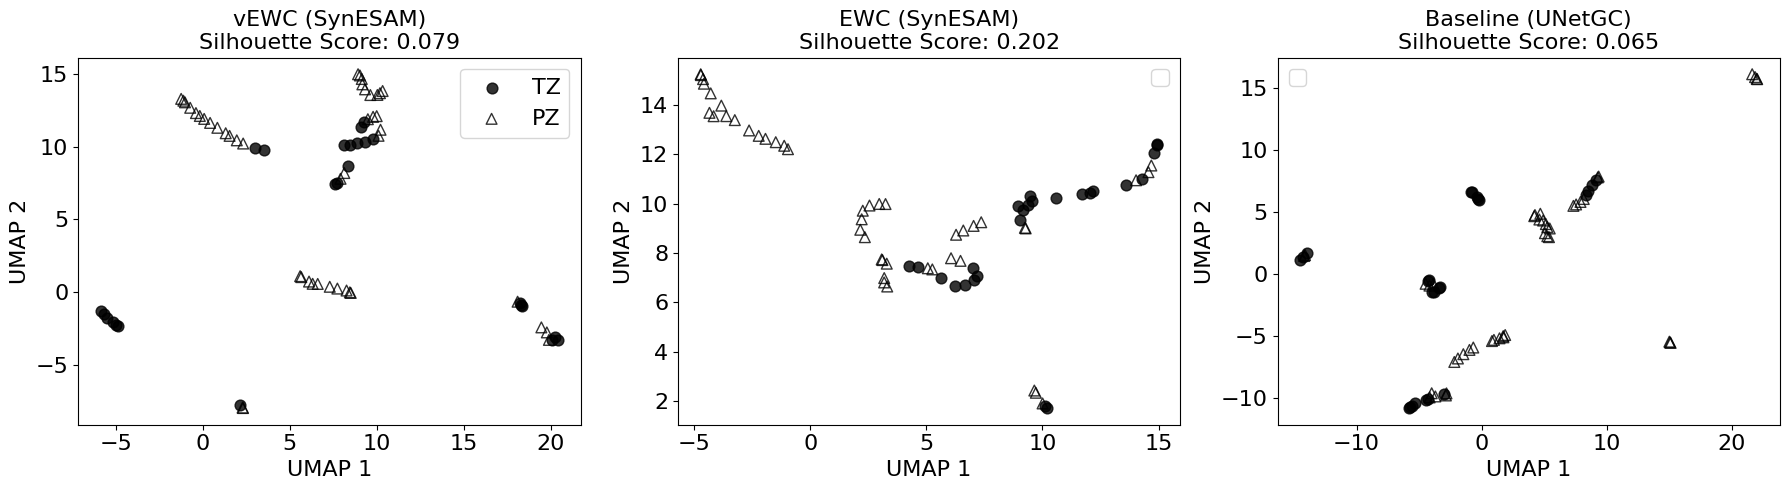

In [43]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
import torch

# === Config ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_list = [model1.to(device), model2.to(device), model3.to(device)]
model_names = ["vEWC", "EWC", "Baseline"]

# === Feature extractors ===
def extract_feature_transformer(model, x_tensor):
    x_tensor = x_tensor.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        _, feat_list = model.transformer_encoder(x_tensor)
        feat = feat_list[31]  # shape: [1, H, W, C]
        feat = feat.permute(0, 3, 1, 2)  # [1, C, H, W]
        pooled = feat.mean(dim=(2, 3))   # [1, C]
        return pooled.squeeze().cpu().numpy()

def extract_feature_baseline(model, x_tensor):
    x_tensor = x_tensor.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        x1 = model.inc(x_tensor)
        x2 = model.down1(x1)
        x3 = model.down2(x2)
        x4 = model.down3(x3)
        x5 = model.down4(x4)
        x = model.up1(x5, x3)
        x = model.up2(x, x2)
        x = model.up3(x, x1)
        x = model.up4(x, x1)
        pooled = x.mean(dim=(2, 3))  # [1, C]
        return pooled.squeeze().cpu().numpy()

# === Preload image-label data ===
image_paths = sorted(glob.glob(r"D:\PhD\Prostate\Data\GSA\sliced_im\*.tif"))[:70]
label_paths = sorted(glob.glob(r"D:\PhD\Prostate\Data\GSA\sliced_lb\*.tif"))[:70]

preloaded_data = []
for img_path, lbl_path in zip(image_paths, label_paths):
    img_tensor, label_np = load_tif_pair(img_path, lbl_path)
    class_id = get_label_class(label_np)
    preloaded_data.append((img_tensor, class_id))

# === Plot settings ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, model, name in zip(axes, model_list, model_names):
    features = []
    classes = []

    # Decide extractor
    model_class = model.__class__.__name__
    extractor = extract_feature_transformer if hasattr(model, "transformer_encoder") else extract_feature_baseline

    # Extract features
    for img_tensor, class_id in preloaded_data:
        feat_vec = extractor(model, img_tensor)
        features.append(feat_vec)
        classes.append(class_id)

    features = np.vstack(features)
    classes = np.array(classes)

    print(f"[{name}] Model class: {model_class}, Feature shape: {features.shape}")
    print(f"[{name}] Class distribution: {np.unique(classes, return_counts=True)}")

    # UMAP
    reducer = umap.UMAP(n_neighbors=3, min_dist=0.2, metric='euclidean', random_state=42)
    embedding = reducer.fit_transform(features)

    # Silhouette
    if len(set(classes)) > 1:
        score = silhouette_score(embedding, classes)
        title = f"{name} ({model_class})\nSilhouette Score: {score:.3f}"
    else:
        title = f"{name} ({model_class})\nOnly one class"

    # Plot
    for label in np.unique(classes):
        mask = classes == label
        marker = 'o' if label == 0 else '^'
        label_name = 'PZ' if label == 1 else 'TZ'
        ax.scatter(embedding[mask, 0], embedding[mask, 1],
                   label=label_name if ax == axes[0] else None,
                   marker=marker,
                   edgecolors='black',
                   facecolors='none' if label else 'black',
                   s=60, alpha=0.8)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("UMAP 1", fontsize=16)
    ax.set_ylabel("UMAP 2", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Shared legend
    ax.legend(fontsize=16)
plt.tight_layout()
plt.show()
